In [7]:
cd /content/drive/MyDrive/oar_seg

/content/drive/MyDrive/oar_seg
/content/drive/MyDrive/oar_seg


In [8]:
#Packages Installed
!pip install nibabel

In [9]:
#packages imported
import numpy as np
import torchsummary
import matplotlib.pyplot as plt
import os
import sys
import nibabel as nib
from PIL import Image
import torch
from torch.autograd import Variable
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, IterableDataset

In [10]:
#set path
path = 'Thoracic_OAR/'

In [11]:
def tensorify(lst):
    """
    List must be nested list of tensors (with no varying lengths within a dimension).
    Nested list of nested lengths [D1, D2, ... DN] -> tensor([D1, D2, ..., DN)

    :return: nested list D
    """
    # base case, if the current list is not nested anymore, make it into tensor
    if type(lst[0]) != list:
        if type(lst) == torch.Tensor:
            return lst
        elif type(lst[0]) == torch.Tensor:
            return torch.stack(lst, dim=0)
        else:  # if the elements of lst are floats or something like that
            return torch.tensor(lst)
    current_dimension_i = len(lst)
    for d_i in range(current_dimension_i):
        tensor = tensorify(lst[d_i])
        lst[d_i] = tensor
    # end of loop lst[d_i] = tensor([D_i, ... D_0])
    tensor_lst = torch.stack(lst, dim=0)
    return tensor_lst


In [12]:
#dataset prep
main_arr_data = []
for i in tqdm(range(1,51)):
  img = nib.load(path + str(i) + '/data.nii.gz')
  img_data = img.get_data()
  for k in range(img_data.shape[2]):
    single_channel = img_data.T[k].reshape(1,512,512)
    main_arr_data.append(torch.cuda.FloatTensor(single_channel))
xd = tensorify(main_arr_data)
del(main_arr_data) 

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """
  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """
100%|██████████| 50/50 [00:22<00:00,  2.23it/s]


In [13]:
#dataset prep
main_arr_labels = []
for i in tqdm(range(1,51)):
  img = nib.load(path + str(i) + '/label.nii.gz')
  img_data = img.get_data()
  for k in range(img_data.shape[2]):
    single_channel = img_data.T[k].reshape(1,512,512)
    main_arr_labels.append(torch.FloatTensor(single_channel))
yd = tensorify(main_arr_labels)
del(main_arr_labels)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """
100%|██████████| 50/50 [00:08<00:00,  6.14it/s]


In [13]:
del(main_arr_data)
del(main_arr_labels)

NameError: ignored

In [14]:
X_train, X_test, y_train, y_test = train_test_split(xd,yd, test_size = 0.2,train_size = 0.8, random_state = 42)

In [15]:
X_train = X_train.to(device = 'cuda')
X_test = X_test.to(device = 'cuda')
y_train = y_train.to(device = 'cuda')
y_test = y_test.to(device = 'cuda')

In [16]:
del(xd)
del(yd)

In [ ]:
#Without Mask
plt.imshow(xd[432][0].T,cmap = 'bone')

NameError: ignored

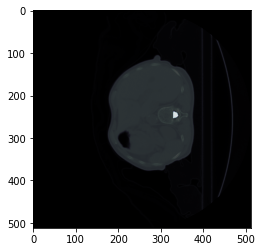

In [ ]:
#With Mask
plt.imshow(np.array(img_data).T[23].T,cmap = 'bone')
plt.imshow(np.array(img_lab_data).T[23].T,alpha= 0.7,cmap = 'bone')


In [17]:
#pytorch
#2d

class UNet_down_block(torch.nn.Module):
    def __init__(self, input_channel, output_channel, down_size):
        super(UNet_down_block, self).__init__()
        self.conv1 = torch.nn.Conv2d(input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.max_pool = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.down_size = down_size

    def forward(self, x):
        if self.down_size:
            x = self.max_pool(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x

class UNet_up_block(torch.nn.Module):
    def __init__(self, prev_channel, input_channel, output_channel):
        super(UNet_up_block, self).__init__()
        self.up_sampling = torch.nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = torch.nn.Conv2d(prev_channel + input_channel, output_channel, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(output_channel)
        self.conv2 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(output_channel)
        self.conv3 = torch.nn.Conv2d(output_channel, output_channel, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(output_channel)
        self.relu = torch.nn.ReLU()

    def forward(self, prev_feature_map, x):
        x = self.up_sampling(x)
        x = torch.cat((x, prev_feature_map), dim=1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        return x


class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.down_block1 = UNet_down_block(1, 16, False)
        self.down_block2 = UNet_down_block(16, 32, True)
        self.down_block3 = UNet_down_block(32, 64, True)
        self.down_block4 = UNet_down_block(64, 128, True)
        self.down_block5 = UNet_down_block(128, 256, True)
        self.down_block6 = UNet_down_block(256, 512, True)
        self.down_block7 = UNet_down_block(512, 1024, True)

        self.mid_conv1 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(1024)
        self.mid_conv2 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(1024)
        self.mid_conv3 = torch.nn.Conv2d(1024, 1024, 3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(1024)

        self.up_block1 = UNet_up_block(512, 1024, 512)
        self.up_block2 = UNet_up_block(256, 512, 256)
        self.up_block3 = UNet_up_block(128, 256, 128)
        self.up_block4 = UNet_up_block(64, 128, 64)
        self.up_block5 = UNet_up_block(32, 64, 32)
        self.up_block6 = UNet_up_block(16, 32, 16)

        self.last_conv1 = torch.nn.Conv2d(16, 16, 3, padding=1)
        self.last_bn = torch.nn.BatchNorm2d(16)
        self.last_conv2 = torch.nn.Conv2d(16, 1, 1, padding=0)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        self.x6 = self.down_block6(self.x5)
        self.x7 = self.down_block7(self.x6)
        self.x7 = self.relu(self.bn1(self.mid_conv1(self.x7)))
        self.x7 = self.relu(self.bn2(self.mid_conv2(self.x7)))
        self.x7 = self.relu(self.bn3(self.mid_conv3(self.x7)))
        x = self.up_block1(self.x6, self.x7)
        x = self.up_block2(self.x5, x)
        x = self.up_block3(self.x4, x)
        x = self.up_block4(self.x3, x)
        x = self.up_block5(self.x2, x)
        x = self.up_block6(self.x1, x)
        x = self.relu(self.last_bn(self.last_conv1(x)))
        x = self.last_conv2(x)
    
        return x



In [7]:
#3d

class UNet_down_block_3d(torch.nn.Module):
  def __init__(self, input_channels, output_channels, down_size):
    super(UNet_down_block_3d, self).__init__()
    self.conv1 = torch.nn.Conv3d(input_channels,output_channels,3,padding = 1)
    self.bn1 = torch.nn.BatchNorm3d(output_channels)
    self.conv2 = torch.nn.Conv3d(output_channels,output_channels,3,padding = 1)
    self.bn2 = torch.nn.BatchNorm3d(output_channels)
    self.conv3 = torch.nn.Conv3d(output_channels,output_channels,3,padding = 1)
    self.bn3 = torch.nn.BatchNorm3d(output_channels)
    self.max_pool = torch.nn.MaxPool3d(3,3)
    self.relu = torch.nn.ReLU()
    self.down_size = down_size

  def forward(self, x):
    if self.down_size:
      x = self.maxpool(x)
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.relu(self.bn3(self.conv3(x)))
    return x

class UNet_up_block_3d(torch.nn.Module):
  def __init__(self, prev_channels, input_channels, output_channels):
    super(UNet_up_block_3d, self).__init__()
    self.up_sampling = torch.nn.Upsample(scale_factor=2, mode = 'bilinear')
    self.conv1 = torch.nn.Conv3d(prev_channels + input_channels,output_channels, 3,padding =1)
    self.bn1 = torch.nn.BatchNorm3d(output_channels)
    self.conv2 = torch.nn.Conv3d(output_channels, output_channels, 3, padding = 1)
    self.bn2 = torch.nn.BatchNorm3d(output_channels)
    self.conv3 = torch.nn.Conv3d(output_channels,output_channels, 3, padding = 1)
    self.bn3 = torch.nn.BatchNorm3d(output_channels)
    self.relu = torch.nn.ReLU()

  def forward(sefl, prev_feature_map, x):
    x = self.up_sampling(x)
    x = torch.cat((x, prev_feature_map), dim = 1)
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.relu(self.bn3(self.conv3(x)))
    return x

class UNet_3d(torch.nn.Module):
  def __init__(self):
    super(UNet_3d, self).__init__()
    self.down_block1 = UNet_down_block_3d(8,16, False)
    self.down_block2 = UNet_down_block_3d(16,32, True)
    self.down_block3 = UNet_down_block_3d(32,64, True)
    self.down_block4 = UNet_down_block_3d(64,128, True)
    self.down_block5 = UNet_down_block_3d(128,256, True)
    self.down_block6 = UNet_down_block_3d(256,512, True)
    self.down_block7 = UNet_down_block_3d(512,1024, True)
    
    self.mid_conv1 = torch.nn.Conv3d(1024, 1024, 3, padding=1)
    self.bn1 = torch.nn.BatchNorm3d(1024)
    self.mid_conv2 = torch.nn.Conv3d(1024, 1024, 3, padding=1)
    self.bn2 = torch.nn.BatchNorm3d(1024)
    self.mid_conv3 = torch.nn.Conv3d(1024, 1024, 3, padding=1)
    self.bn3 = torch.nn.BatchNorm3d(1024)

    self.up_block1 = UNet_up_block_3d(512,1024,512)
    self.up_block2 = UNet_up_block_3d(256,512,256)
    self.up_block3 = UNet_up_block_3d(128,256,128)
    self.up_block4 = UNet_up_block_3d(64,128,64)
    self.up_block5 = UNet_up_block_3d(32,64,32)
    self.up_block6 = UNet_up_block_3d(16,32,16)

    self.last_conv1 = torch.nn.Conv3d(16,16,3, padding = 1)
    self.last_bn = torch.nn.BatchNorm3d(16)
    self.last_conv2 = torch.nn.Conv3d(16,8,1,padding = 1)
    self.relu = torch.nn.ReLU()

  def forward(self, x):
        self.x1 = self.down_block1(x)
        self.x2 = self.down_block2(self.x1)
        self.x3 = self.down_block3(self.x2)
        self.x4 = self.down_block4(self.x3)
        self.x5 = self.down_block5(self.x4)
        self.x6 = self.down_block6(self.x5)
        self.x7 = self.down_block7(self.x6)
        self.x7 = self.relu(self.bn1(self.mid_conv1(self.x7)))
        self.x7 = self.relu(self.bn2(self.mid_conv2(self.x7)))
        self.x7 = self.relu(self.bn3(self.mid_conv3(self.x7)))
        x = self.up_block1(self.x6, self.x7)
        x = self.up_block2(self.x5, x)
        x = self.up_block3(self.x4, x)
        x = self.up_block4(self.x3, x)
        x = self.up_block5(self.x2, x)
        x = self.up_block6(self.x1, x)
        x = self.relu(self.last_bn(self.last_conv1(x)))
        x = self.last_conv2(x)
        return x
    



In [ ]:
if __name__ == '__main__':
    net = UNet().cuda()
    print(net)

    test_x = Variable(torch.cuda.FloatTensor(1, 8, 512, 512))
    out_x = net(test_x)

    print(out_x.size())

In [12]:
import torchsummary
torchsummary.summary(UNet().cuda(),(1,512,512),1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 16, 512, 512]             160
       BatchNorm2d-2          [1, 16, 512, 512]              32
              ReLU-3          [1, 16, 512, 512]               0
            Conv2d-4          [1, 16, 512, 512]           2,320
       BatchNorm2d-5          [1, 16, 512, 512]              32
              ReLU-6          [1, 16, 512, 512]               0
            Conv2d-7          [1, 16, 512, 512]           2,320
       BatchNorm2d-8          [1, 16, 512, 512]              32
              ReLU-9          [1, 16, 512, 512]               0
  UNet_down_block-10          [1, 16, 512, 512]               0
        MaxPool2d-11          [1, 16, 256, 256]               0
           Conv2d-12          [1, 32, 256, 256]           4,640
      BatchNorm2d-13          [1, 32, 256, 256]              64
             ReLU-14          [1, 32, 2

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [14]:
def tensorify(lst):
    """
    List must be nested list of tensors (with no varying lengths within a dimension).
    Nested list of nested lengths [D1, D2, ... DN] -> tensor([D1, D2, ..., DN)

    :return: nested list D
    """
    # base case, if the current list is not nested anymore, make it into tensor
    if type(lst[0]) != list:
        if type(lst) == torch.Tensor:
            return lst
        elif type(lst[0]) == torch.Tensor:
            return torch.stack(lst, dim=0)
        else:  # if the elements of lst are floats or something like that
            return torch.tensor(lst)
    current_dimension_i = len(lst)
    for d_i in range(current_dimension_i):
        tensor = tensorify(lst[d_i])
        lst[d_i] = tensor
    # end of loop lst[d_i] = tensor([D_i, ... D_0])
    tensor_lst = torch.stack(lst, dim=0)
    return tensor_lst

In [18]:
train_ds = TensorDataset(X_train,y_train)
valid_ds = TensorDataset(X_test,y_test)


In [ ]:
tensorify(X_train).shape

In [19]:
bs = 1

# Converts the TensorDataset into a DataLoader object and combines into one DataLoaders object (a basic wrapper
# around several DataLoader objects). 
train_dl = DataLoader(train_ds, batch_size=bs)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)


In [20]:
X_train = X_train.to(device = 'cuda')

In [20]:
model = UNet().cuda()

In [15]:
print(model)

UNet(
  (down_block1): UNet_down_block(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (down_block2): UNet_down_block(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, af

In [16]:
model.eval()

UNet(
  (down_block1): UNet_down_block(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (down_block2): UNet_down_block(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, af

In [21]:

# define the optimization
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)


In [22]:
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
# zero the parameter gradients
        optimizer.zero_grad()
# forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
# print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
# print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


[1,  2000] loss: 0.098
[1,  2000] loss: 0.000
[2,  2000] loss: 0.041
[2,  2000] loss: 0.000
[3,  2000] loss: 0.035
[3,  2000] loss: 0.000
[4,  2000] loss: 0.031
[4,  2000] loss: 0.000
[5,  2000] loss: 0.029
[5,  2000] loss: 0.000
[6,  2000] loss: 0.028
[6,  2000] loss: 0.000
[7,  2000] loss: 0.026
[7,  2000] loss: 0.000
[8,  2000] loss: 0.026
[8,  2000] loss: 0.000
[9,  2000] loss: 0.024
[9,  2000] loss: 0.000
[10,  2000] loss: 0.024
[10,  2000] loss: 0.000
Finished Training


In [22]:
model(y_train[0])

UNet(
  (down_block1): UNet_down_block(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
  )
  (down_block2): UNet_down_block(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, af

In [39]:
op = model(y_train[0].unsqueeze(0))[0]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [44]:
op = op.cpu()

In [47]:
op = op.detach()

In [49]:
op = op.numpy()

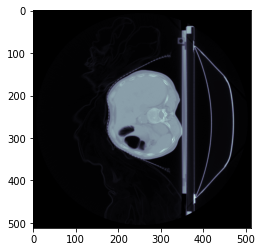

In [40]:
plt.imshow(X_train[4].cpu().detach().numpy()[0].T,cmap = 'bone')


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3455: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


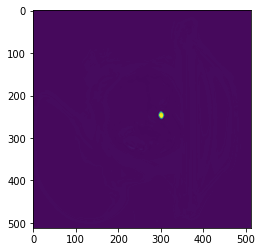

In [41]:

plt.imshow(model(X_train[4].unsqueeze(0))[0].cpu().detach().numpy()[0].T)

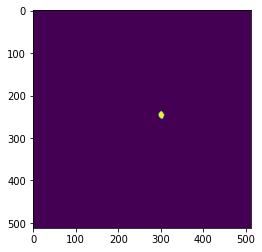

In [42]:
plt.imshow(y_train[4].cpu().detach().numpy()[0].T)

In [47]:
torch.save(model,'OARSEGStdUNET.pt')

In [49]:
os.listdir()

['Thoracic_OAR',
 'movie.gif',
 'main.gif',
 'lable.gif',
 '.ipynb_checkpoints',
 'DataStrea.py',
 'hello_world.cu',
 'hello_world.c',
 'rmm.ipynb',
 'OARSEGStdUNET.pt']